In [1]:
%load_ext watermark
%load_ext autoreload

import numpy as np
import xarray as xr
import xcdat as xc
import sparse
import time

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cmocean.cm as cmo

import flat10_leafcn_utils as flat
%aimport flat10_leafcn_utils
%autoreload 1

%watermark -iv -co -v

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

conda environment: clisci

cartopy   : 0.22.0
xcdat     : 0.6.0
numpy     : 1.24.4
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
cmocean   : 3.0.3
sparse    : 0.14.0
xarray    : 2023.10.1
matplotlib: 3.8.0



# Sparse array method for mapping (landunit) --> (lat,lon,typlunit)

In [2]:
def to_sparse(data, lunit, jxy, ixy, shape):
    """
    """
    # Construct a list of coordinate locations at which data exists
    # -> works for arbitrary number of dimensions but assumes that the last dimension
    #    is the "stacked" dimension i.e. "landunit"
    if data.ndim == 1:
        coords = np.stack([lunit, jxy - 1, ixy - 1], axis=0)
    elif data.ndim == 2:
        # Generate some repeated time indexes
        # [0 0 0 ... 1 1 1... ]
        itime = np.repeat(np.arange(data.shape[0]), data.shape[1])
        # Expand lunit and friends for all time instants
        # by sequentially concatenating each array for each time instants
        tostack = [np.concatenate([array] * data.shape[0]) for array in [lunit, jxy - 1, ixy - 1]]
        coords = np.stack([itime] + tostack, axis=0)
    else:
        raise NotImplementedError
    
    return sparse.COO(
        coords=coords,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=np.nan,
    )


def convert_lunit_variables_to_sparse(dataset, lunitnames):
    """
    """

    # Extract landunit variables
    lunits = xr.Dataset({k: v for k, v in dataset.items() if "landunit" in v.dims})

    # Extract coordinate index locations
    ixy = dataset.land1d_ixy.astype(int)
    jxy = dataset.land1d_jxy.astype(int)
    landunit = dataset.cols1d_itype_lunit.astype(int)
    nlunit = len(lunitnames.data)

    # Expected shape of sparse arrays to pass to 'to_sparse' (exclude time)
    output_sizes = {
        "landunit": nlunit,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()

    # Loop over variables so we can specify the appropriate dtype
    for var in lunits:
        result[var] = xr.apply_ufunc(
            to_sparse,
            lunits[var],
            landunit,
            jxy,
            ixy,
            kwargs=dict(shape=tuple(output_sizes.values())),
            input_core_dims=[["landunit"], ["landunit"], ["landunit"], ["landunit"]],
            output_core_dims=[["landunit", "lat", "lon"]],
            dask="parallelized",
            dask_gufunc_kwargs=dict(
                meta=sparse.COO(np.array([], dtype=lunits[var].dtype)),
                output_sizes=output_sizes,
            ),
            keep_attrs=True,
        )
    
    # Copy over coordinate variables lat and lon
    result = result.update(dataset[["lat", "lon"]])
    result["landunit"] = lunitnames.data

    # Save the dataset attributes
    result.attrs = dataset.attrs
    return result

In [107]:
# start = time.time()
# sparse_latlon_dataset = convert_lunit_variables_to_sparse(dataset, landunitlist)
# print(f"time to generate sparse array: {time.time() - start:.2f} seconds")

# sparse_latlon_dataset = sparse_latlon_dataset.assign_coords({"landunit_name": landunitnames})

# start = time.time()
# dense_dataset = sparse_latlon_dataset["TOTSOMC"].data.todense()
# dense_dataset = xr.DataArray(
#     data=dense_dataset,
#     dims=["time", "landunit", "lat", "lon"],
#     coords=dict(
#         time=sparse_latlon_dataset.time,
#         landunit=sparse_latlon_dataset.vegtype,
#         landunit_name=(('landunit'), landunitnames.values),
#         lat=sparse_latlon_dataset.lat,
#         lon=sparse_latlon_dataset.lon,
#     )
# )
# print(f"time to convert to dense array: {time.time() - start:.2f} seconds")

# Iteration method for mapping (landunit) --> (lat,lon,typlunit)

In [2]:
typlunit_name = np.array([
    "vegetated_or_bare_soil",
    "crop",
    "UNUSED",
    "landice_multiple_elevation_classes",
    "deep_lake",
    "wetland",
    "urban_tbd",
    "urban_hd",
    "urban_md",
])
typlunit = np.arange(typlunit_name.size)

dataset = xr.open_mfdataset("~/scratch/archive/b.e21.B1850.f09_g17.FLAT10ctrl-esm.001.leafcn_high.bgc_spinup/lnd/hist/b.e21.B1850.f09_g17.FLAT10ctrl-esm.001.leafcn_high.bgc_spinup.clm2.h4.*.nc")

landunit = dataset["landunit"]

lat = dataset["lat"]
lon = dataset["lon"]

land1d_ixy = dataset["land1d_ixy"].astype(int)
land1d_jxy = dataset["land1d_jxy"].astype(int)

land1d_lat = dataset["land1d_lat"]
land1d_lon = dataset["land1d_lon"]

land1d_ityplunit = dataset["land1d_ityplunit"].astype(int)

## Complexity analysis and timing

In [77]:
var = "TOTSOMC"

times = []

for i in [500, 1000, 2000, 4000]:
    start = time.time()

    gridded = xr.DataArray(
        data=np.zeros((lat.size, lon.size, typlunit.size)),
        dims=["lat", "lon", "typlunit"],
        coords={"lat": lat, "lon": lon, "typlunit": np.arange(9)},
        name=var,
        attrs=dataset[var].attrs,
    )

    for lunit in range(i):
        jxy = land1d_jxy.isel(time=0, landunit=lunit).values
        ixy = land1d_ixy.isel(time=0, landunit=lunit).values
        ityplunit = land1d_ityplunit.isel(time=0, landunit=lunit).values

        gridded[jxy-1, ixy-1, ityplunit] = dataset[var].isel(time=0, landunit=lunit).values
    
    times.append(time.time() - start)

print(times)

[4.7839133739471436, 9.015344619750977, 18.210283041000366, 39.796147108078]


## Example with single time step

In [81]:
var = "TOTSOMC"

start = time.time()

gridded = xr.DataArray(
    data=np.zeros((lat.size, lon.size, typlunit.size)),
    dims=["lat", "lon", "typlunit"],
    coords={
        "lat": lat,
        "lon": lon,
        "typlunit": np.arange(9),
        "typlunit_name": (("typlunit"), typlunit_name)},
    name=var,
    attrs=dataset[var].attrs,
)

for lunit in range(landunit.size):
    jxy = land1d_jxy.isel(time=0, landunit=lunit).values
    ixy = land1d_ixy.isel(time=0, landunit=lunit).values
    ityplunit = land1d_ityplunit.isel(time=0, landunit=lunit).values

    gridded[jxy-1, ixy-1, ityplunit-1] = dataset[var].isel(time=0, landunit=lunit).values

print(time.time() - start)

461.58032965660095


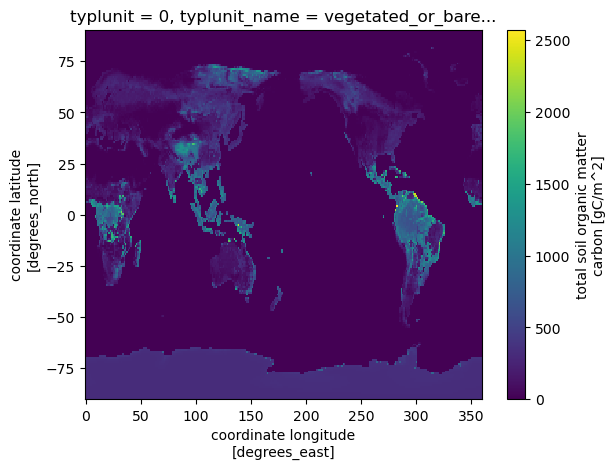

In [92]:
gridded.isel(typlunit=0).plot()

In [11]:
orig_totsomc = flat.get_flat10_variable('TOTSOMC', 'lnd', 'leafcn_high', time_range=['0037-01', '0042-12'], experiment='ctrl-esm', use_mfdataset=False, verbose=True)
orig_totsomc = orig_totsomc.sel(time=slice('0038-01', '0042-12'))
assert orig_totsomc.time.size == 60
orig_totsomc = orig_totsomc.groupby("time.year").mean()
orig_totsomc.coords["year"] = np.arange(5)


spin_totsomc = flat.get_flat10_variable('TOTSOMC', 'lnd', 'leafcn_high.bgc_spinup.check_startup', time_range=['0001-01', '0006-12'], experiment='ctrl-esm', use_mfdataset=False, verbose=True)
spin_totsomc = spin_totsomc.sel(time=slice('0002-01', '0006-12'))
assert spin_totsomc.time.size == 60
spin_totsomc = spin_totsomc.groupby("time.year").mean()
spin_totsomc.coords["year"] = np.arange(5)

bgc_totsomc = xc.open_dataset("/glade/work/bbuchovecky/FLAT10_analysis/b.e21.B1850.f09_g17.FLAT10ctrl-esm.001.leafcn_high.bgc_spinup/lnd/hist/b.e21.B1850.f09_g17.FLAT10ctrl-esm.001.leafcn_high.bgc_spinup.clm2.h4.000101-000701.TOTSOMC.nc")
bgc_totsomc = bgc_totsomc["TOTSOMC"].sel(time=slice("0002-01", "0006-12"))
assert bgc_totsomc.time.size == 5
bgc_totsomc = bgc_totsomc.rename({"time": "year"})
bgc_totsomc.coords['year'] = np.arange(5)

length of timeseries [month]: 0072
length of timeseries [month]: 0072


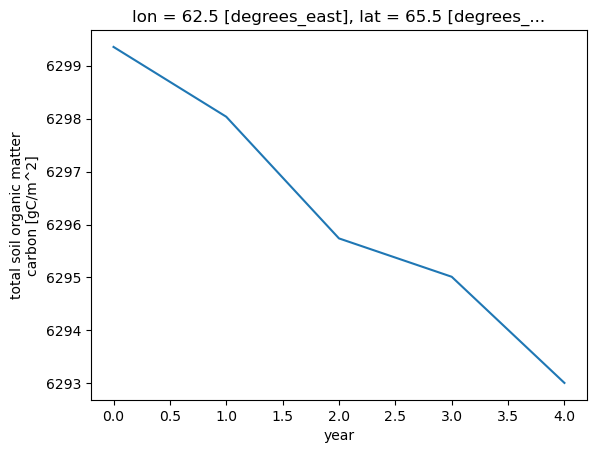

In [25]:
iorig.plot()

lat: 60.79
lon: 237.50


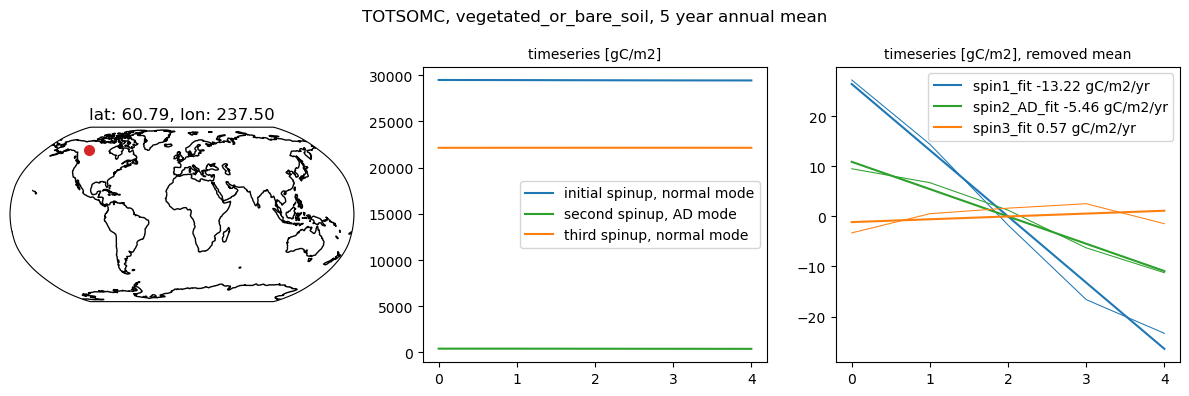

In [119]:
ilunit = 0
ilat = 160
ilon = 190

print(f"lat: {orig_totsomc.lat.isel(lat=ilat).values:.2f}")
print(f"lon: {orig_totsomc.lon.isel(lon=ilon).values:.2f}")

fig = plt.figure(figsize=(12, 4))
mapax = fig.add_subplot(131, projection=ccrs.Robinson())
tndax = fig.add_subplot(132)
cntax = fig.add_subplot(133)

mapax.plot(orig_totsomc.lon.isel(lon=ilon).values, orig_totsomc.lat.isel(lat=ilat).values, marker='o', ms=7, c='tab:red', transform=ccrs.PlateCarree())
mapax.set_global()
mapax.coastlines()
mapax.set_title(f"lat: {orig_totsomc.lat.isel(lat=ilat).values:.2f}, lon: {orig_totsomc.lon.isel(lon=ilon).values:.2f}")

iorig = orig_totsomc.isel(lat=ilat, lon=ilon)
ibgc = bgc_totsomc.isel(lat=ilat, lon=ilon, typlunit=ilunit)
ispin = spin_totsomc.isel(lat=ilat, lon=ilon)

iorig_fit = iorig.polyfit(dim="year", deg=1).polyfit_coefficients
ibgc_fit = ibgc.polyfit(dim="year", deg=1).polyfit_coefficients
ispin_fit = ispin.polyfit(dim="year", deg=1).polyfit_coefficients

tndax.plot(iorig.year, iorig, label="initial spinup, normal mode", c="tab:blue")
tndax.plot(ibgc.year, ibgc, label="second spinup, AD mode", c="tab:green")
tndax.plot(ispin.year, ispin, label="third spinup, normal mode", c="tab:orange")

tndax.set_title("timeseries [gC/m2]", fontsize=10)
tndax.legend()

cntax.plot(iorig.year, iorig - iorig.mean(), c="tab:blue", lw=0.75)
cntax.plot(iorig.year, (iorig_fit[1] + iorig_fit[0] * iorig.year) - iorig.mean(), label=f"spin1_fit {iorig_fit[0]:.2f} gC/m2/yr", c="tab:blue")

cntax.plot(ibgc.year, ibgc - ibgc.mean(), c="tab:green", lw=0.75)
cntax.plot(ibgc.year, (ibgc_fit[1] + ibgc_fit[0] * ibgc.year) - ibgc.mean(), label=f"spin2_AD_fit {ibgc_fit[0]:.2f} gC/m2/yr", c="tab:green")

cntax.plot(ispin.year, ispin - ispin.mean(), c="tab:orange", lw=0.75)
cntax.plot(ispin.year, (ispin_fit[1] + ispin_fit[0] * ispin.year) - ispin.mean(), label=f"spin3_fit {ispin_fit[0]:.2f} gC/m2/yr", c="tab:orange")

cntax.set_title("timeseries [gC/m2], removed mean", fontsize=10)
cntax.legend()

plt.suptitle(f"TOTSOMC, {typlunit_name[ilunit]}, 5 year annual mean", fontsize=12)
plt.tight_layout()

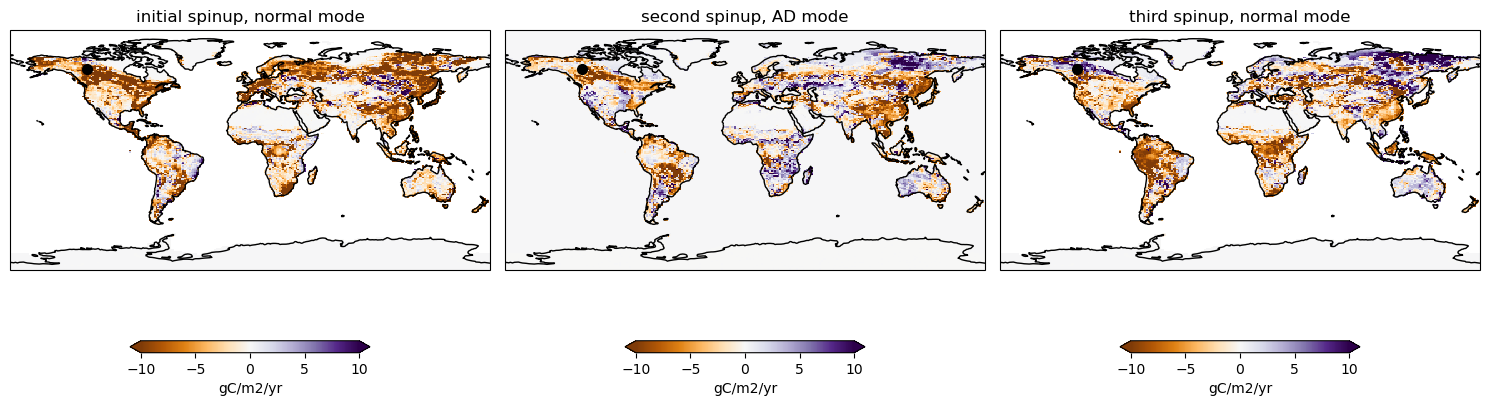

In [127]:
orig_fit = orig_totsomc.polyfit(dim="year", deg=1).polyfit_coefficients
spin_fit = spin_totsomc.polyfit(dim="year", deg=1).polyfit_coefficients
bgc_fit = bgc_totsomc.polyfit(dim="year", deg=1).polyfit_coefficients

fig = plt.figure(figsize=(15,5))
origax = fig.add_subplot(131, projection=ccrs.PlateCarree())
bgcax = fig.add_subplot(132, projection=ccrs.PlateCarree())
spinax = fig.add_subplot(133, projection=ccrs.PlateCarree())

orig_fit[0].plot.pcolormesh(
    ax=origax, transform=ccrs.PlateCarree(),
    cmap="PuOr", vmin=-10, vmax=10,
    cbar_kwargs={
        "label": "gC/m2/yr",
        "orientation": "horizontal",
        "location": "bottom",
        "shrink": 0.5,},
    )
origax.set_title("initial spinup, normal mode")

bgc_fit[0].isel(typlunit=0).plot.pcolormesh(
    ax=bgcax, transform=ccrs.PlateCarree(),
    cmap="PuOr", vmin=-10, vmax=10,
    cbar_kwargs={
        "label": "gC/m2/yr",
        "orientation": "horizontal",
        "location": "bottom",
        "shrink": 0.5,},
    )
bgcax.set_title("second spinup, AD mode")

spin_fit[0].plot.pcolormesh(
    ax=spinax, transform=ccrs.PlateCarree(),
    cmap="PuOr", vmin=-10, vmax=10,
    cbar_kwargs={
        "label": "gC/m2/yr",
        "orientation": "horizontal",
        "location": "bottom",
        "shrink": 0.5,},
    )
spinax.set_title("third spinup, normal mode")

for ax in [origax, bgcax, spinax]:
    ax.coastlines()
    ax.plot(orig_totsomc.lon.isel(lon=ilon).values, orig_totsomc.lat.isel(lat=ilat).values, marker='o', ms=7, c='k', transform=ccrs.PlateCarree())

plt.tight_layout()